In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

In [2]:
cwd = os.getcwd()

# Data analysis and comparison

This script post-process the results obtained from the Radiance 3-phase simulation, for each of the three blind control strategies assessed in the related paper (current, rule-based, optimised), and compare their performance in terms of daylight access, visual comfort and view out.

## Display slat angles for the three strategies

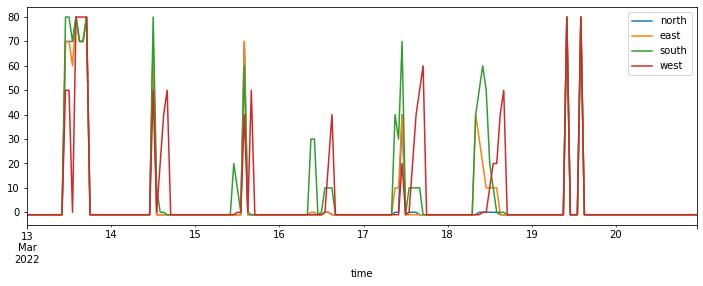

In [4]:
slats = pd.read_csv('HD_slatangles_hourlyrounded.csv', index_col=0, parse_dates=True)
slats.columns = ['north','east','south','west']

fig, ax = plt.subplots(figsize=(12,4))
slats.plot(ax=ax)
plt.show()

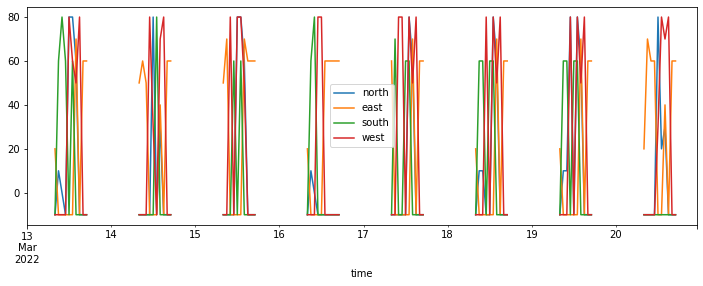

In [7]:
optslats = pd.read_csv('optctrl.csv', index_col=0, parse_dates=True)
optslats = optslats.loc[:,['nctrl','ectrl','sctrl','wctrl']]
optslats.columns = ['north','east','south','west']
optslats.index = optslats.index.map(lambda t: t.replace(year=2022))
optslats = optslats.reindex(slats.index)

fig, ax = plt.subplots(figsize=(12,4))
optslats.plot(ax=ax)
plt.show()

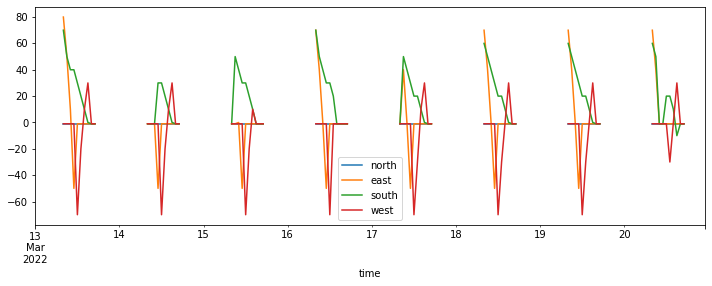

In [8]:
ruleslats = pd.read_csv('rulebased.csv', index_col=0, parse_dates=True)
ruleslats = ruleslats.loc[:,['north','east','south','west']]
ruleslats.index = ruleslats.index.map(lambda t: t.replace(year=2022))
ruleslats = ruleslats.reindex(slats.index)

fig, ax = plt.subplots(figsize=(12,4))
ruleslats.plot(ax=ax)
plt.show()

## Join results and calculate all KPIs (view, daylight access / lighting energy, glare)

In [9]:
all_kpi = pd.DataFrame(index=['Eh','Glare','View','Sum'], columns=['Opt','Rule-based','Current'])
all_kpi_weekdays = pd.DataFrame(index=['Eh','Glare','View','Sum'], columns=['Opt','Rule-based','Current'])

56
76
61


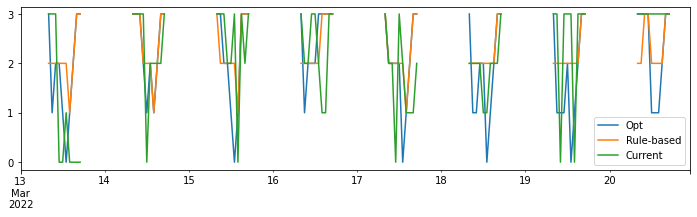

In [10]:
def view_ix(df, columns, strategy):
    freq = []
    for i in df.index:
        j = 0
        if df.loc[i,columns[0]]<=0:
            j+=1
        if df.loc[i,columns[1]]<=0:
            j+=1
        if df.loc[i,columns[2]]<=0:
            j+=1
        freq.append(j)

    freq = pd.Series(freq, index=df.index, dtype=int)
    freq.index.name = ''
    freq = freq.resample('H').asfreq()
    freq[(freq.index.hour < 8) | (freq.index.hour >= 18)] = np.nan
    all_kpi.loc['View',strategy] = freq[freq>=2].count()
    all_kpi_weekdays.loc['View',strategy] = freq[(freq>=2) & (freq.index.weekday<5)].count()
    print(freq[freq>=2].count())
    return freq

freq_opt = view_ix(optslats, ['north','south','west'], 'Opt')
freq_rule = view_ix(ruleslats, ['north','south','west'], 'Rule-based')
freq_hd = view_ix(slats, ['north','south','west'], 'Current')

fig, ax = plt.subplots(figsize=(12,3))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
freq_opt.plot(ax=ax, label='Opt')
freq_rule.plot(ax=ax, label='Rule-based')
freq_hd.plot(ax=ax, label='Current')
# plt.bar(range(len(freq_hd)), freq_hd)
plt.legend()
plt.show()

In [11]:
opt_res = pd.read_csv('Results/opt_illum_dgp.csv', index_col=0, parse_dates=True)
opt_res.index = opt_res.index.map(lambda t: t.replace(year=2022))
rb_res = pd.read_csv('Results/rb_illum_dgp.csv', index_col=0, parse_dates=True)
rb_res.index = rb_res.index.map(lambda t: t.replace(year=2022))
hd_res = pd.read_csv('Results/hd_illum_dgp.csv', index_col=0, parse_dates=True)
hd_res.index = hd_res.index.map(lambda t: t.replace(year=2022))

opt_res = opt_res.reindex(slats.index)
rb_res = rb_res.reindex(slats.index)
hd_res = hd_res.reindex(slats.index)

In [12]:
def get_energy(df):
    hours = df[df<300].count()
    lit_en = hours * 7.45 * 318
    return hours, lit_en

opt_lit_en = get_energy(opt_res['avg_wpi'])
print(opt_lit_en)
rb_lit_en = get_energy(rb_res['avg_wpi'])
print(rb_lit_en)
hd_lit_en = get_energy(hd_res['avg_wpi'])
print(hd_lit_en)

all_kpi.loc['Eh','Opt'] = opt_res['avg_wpi'][opt_res['avg_wpi']>=300].count()
all_kpi.loc['Eh','Rule-based'] = rb_res['avg_wpi'][rb_res['avg_wpi']>=300].count()
all_kpi.loc['Eh','Current'] = hd_res['avg_wpi'][hd_res['avg_wpi']>=300].count()

all_kpi_weekdays.loc['Eh','Opt'] = opt_res['avg_wpi'][(opt_res['avg_wpi']>=300) & (opt_res.index.weekday<5)].count()
all_kpi_weekdays.loc['Eh','Rule-based'] = rb_res['avg_wpi'][(rb_res['avg_wpi']>=300) & (rb_res.index.weekday<5)].count()
all_kpi_weekdays.loc['Eh','Current'] = hd_res['avg_wpi'][(hd_res['avg_wpi']>=300) & (hd_res.index.weekday<5)].count()

(2, 4738.2)
(0, 0.0)
(9, 21321.899999999998)


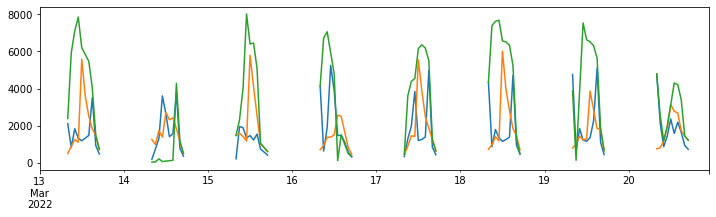

In [13]:
fig, ax = plt.subplots(figsize=(12,3))
opt_res['avg_wpi'].plot(ax=ax)
rb_res['avg_wpi'].plot(ax=ax)
hd_res['avg_wpi'].plot(ax=ax)
plt.show()

70
33
29


<AxesSubplot:>

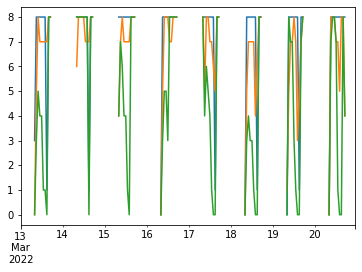

In [14]:
def glare_ix(df, columns, strategy):
    n = []
    for i in df.index:
        dgp_lim = 0.38
        ni = df.loc[i,columns][df.loc[i,columns] < dgp_lim].count()
        n.append(ni)

    n = pd.Series(n, index=df.index, dtype=int)
    n.index.name = ''
    n[(n.index.hour < 8) | (n.index.hour >= 18)] = np.nan
    all_kpi.loc['Glare',strategy] = n[n==8].count()
    all_kpi_weekdays.loc['Glare',strategy] = n[(n==8) & (n.index.weekday < 5)].count()
    print(n[n==8].count())
    return n

glare_opt = glare_ix(opt_res, opt_res.columns[9:], 'Opt')
glare_rb = glare_ix(rb_res, rb_res.columns[9:], 'Rule-based')
glare_hd = glare_ix(hd_res, hd_res.columns[9:], 'Current')

glare_opt.plot()
glare_rb.plot()
glare_hd.plot()

## Visualise performance for each strategy

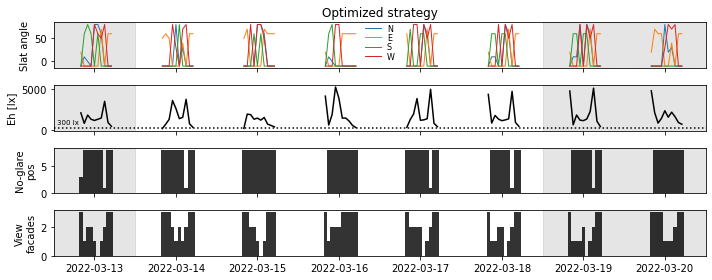

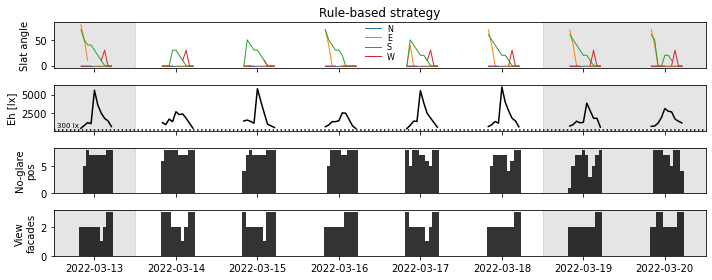

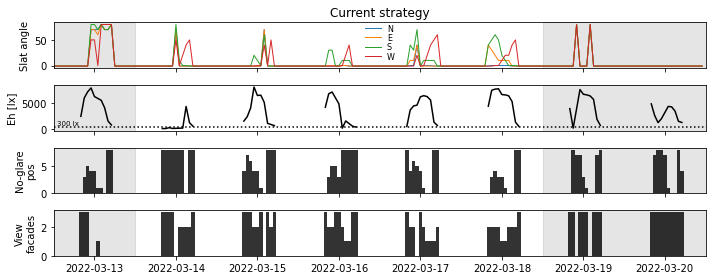

In [15]:
def plot_strategy(df_slats, df_Eh, df_glare, df_view, title):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,4), sharex=True)

    w = 1

    axs[0].set_title(title)
    axs[0].plot(df_slats.values, lw=1, label=['N','E','S','W'])
    axs[0].set_ylabel('Slat angle')
    axs[0].legend(fontsize=8, frameon=False, labelspacing=.05)

    axs[1].plot(df_Eh.values, color='k')
    axs[1].axhline(300, ls=':', color='k')
    axs[1].text(1,700, '300 lx', fontsize=7)
    axs[1].set_ylabel('Eh [lx]')

    axs[2].bar(range(len(df_glare)), df_glare.values, width=w, color='k', alpha=.8)
    axs[2].set_ylabel('No-glare\npos')

    axs[3].bar(range(len(df_view)), df_view.values, width=w, color='k', alpha=.8)
    axs[3].set_ylabel('View\nfacades')

    for ax in axs:
        ax.axvspan(0,24, color='k', alpha=.1)
        ax.axvspan(144, 192, color='k', alpha=.1)
        ax.set_xlim(0,192)

    axs[3].set_xticks([12+i*24 for i in range(8)])
    axs[3].set_xticklabels([str(i)[:10] for i in slats.resample('D').mean().index])

    plt.tight_layout()
    plt.savefig('img/%s.pdf' % title.replace(" ",""), bbox_inches='tight')
    plt.show()
    
plot_strategy(optslats, opt_res['avg_wpi'], glare_opt, freq_opt, 'Optimized strategy')
plot_strategy(ruleslats[ruleslats>=-1], rb_res['avg_wpi'], glare_rb, freq_rule, 'Rule-based strategy')
plot_strategy(slats, hd_res['avg_wpi'], glare_hd, freq_hd, 'Current strategy')

## Summarise performance in a single index and visualise it

In [16]:
for c in all_kpi.columns:
    all_kpi.loc['Sum',c] = all_kpi.loc[['Eh','Glare','View'],c].mean()
    
print(all_kpi)

for c in all_kpi_weekdays.columns:
    all_kpi_weekdays.loc['Sum',c] = all_kpi_weekdays.loc[['Eh','Glare','View'],c].mean()
    
print(all_kpi_weekdays)

        Opt Rule-based    Current
Eh       78         80         71
Glare    70         33         29
View     56         76         61
Sum    68.0       63.0  53.666667
             Opt Rule-based    Current
Eh            48         50         42
Glare         45         23         22
View          38         47         40
Sum    43.666667       40.0  34.666667


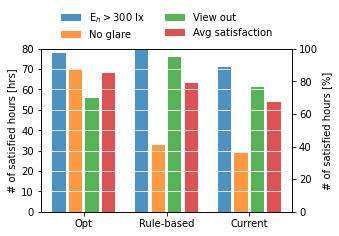

In [17]:
fig, ax = plt.subplots(figsize=(4.5,3))

ax.grid(axis='y', color='w')

for i,ix in enumerate(all_kpi.index):
    ax.bar(range(i,14,5), all_kpi.loc[ix,:], alpha=.8)

ax.set_ylim(0,80)
ax2 = ax.twinx()
ax2.set_ylim(0,100)
ax2.set_ylabel('# of satisfied hours [%]')

ax.set_xticks([1.5,6.5,11.5])
ax.set_xticklabels(all_kpi.columns)
ax.set_ylabel('# of satisfied hours [hrs]')

ax.legend(['E$_h >$300 lx','No glare','View out','Avg satisfaction'], frameon=False, ncol=2, 
          bbox_to_anchor=(.5,1), loc='lower center')

plt.savefig('img/summary.pdf', bbox_inches='tight')    
plt.show()